In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pysam
import numpy as np
import seaborn as sns
import pandas as pd
import time

In [2]:
def bootstrapSamp(counts_runA, cov_tot):
    np.random.seed()
    pb_runA = counts_runA/np.sum(counts_runA)
    _q = np.random.choice(range(0,len(counts_runA)),size=cov_tot,replace=True,p=pb_runA.astype(np.float))
    sim = np.zeros(len(pb_runA))
    for idx in _q:
        sim[idx] += 1
    return sim

# FFC: population freaction change
def compute_FFC(base_run, pcr_run, include_nan=False):
    a = base_run/np.sum(base_run)
    b = pcr_run/np.sum(pcr_run)
    old_settings = np.seterr(divide='ignore',invalid='ignore')
    ampratio = b/a
    if include_nan == False:
        ffc = ampratio[np.isfinite(ampratio)]
    else:
        ffc = ampratio
    _=np.seterr(**old_settings)  # reset to default
    return ffc

## PCR sim
def binormSim(n, p, cyc=10):
    # simulate the number of molecules after "c" cycle
    # n: number of template molecules
    # p: probability of success PCR
    for i in range(cyc):
        n += np.random.binomial(n, p, 1)
    return n.item(0)

## Process experimental data

In [ ]:
"""
data set; this is triplicate experiments.
Bias0.npy, Bias6.npy, Bias12.npy is the experimental PCR data with average 200 copy number (represening the master pool)
Bias1.npy, Bias7.npy, Bias13.npy is the experimental PCR data with average 113 copy number
Bias2.npy, Bias8.npy, Bias14.npy is the experimental PCR data with average 66 copy number
Bias3.npy, Bias9.npy, Bias15.npy is the experimental PCR data with average 32 copy number
Bias4.npy, Bias10.npy, Bias16.npy is the experimental PCR data with average 16 copy number
Bias5.npy, Bias11.npy, Bias17.npy is the experimental PCR data with average 8 copy number
""" 

In [4]:
# calculate the statistics of CV and ffc
nseqs=7373
SEQCov = 200*nseqs
exp_data_list = []
CVs_exp = []
ffcSTDs_exp = []

raw_data0 = np.load("./data/fig5_expdata/Bias0.npy")
for i in range(1,6):
    exp_data = np.load("./data/fig5_expdata/Bias"+str(i)+".npy")
    bsData = bootstrapSamp(exp_data, SEQCov)
    ffc = compute_FFC(raw_data0, bsData)
    ffcSTDs_exp.append(np.std(ffc))
    CVs_exp.append(np.std(bsData)/np.mean(bsData))

raw_data1 = np.load("./data/fig5_expdata/Bias6.npy")
for i in range(7,12):
    exp_data = np.load("./data/fig5_expdata/Bias"+str(i)+".npy")
    bsData = bootstrapSamp(exp_data, SEQCov)
    CVs_exp.append(np.std(bsData)/np.mean(bsData))
    ffc = compute_FFC(raw_data1, bsData)
    ffcSTDs_exp.append(np.std(ffc))    

raw_data2 = np.load("./data/fig5_expdata/Bias12.npy")
for i in range(13,18):
    exp_data = np.load("./data/fig5_expdata/Bias"+str(i)+".npy")
    bsData = bootstrapSamp(exp_data, SEQCov)
    CVs_exp.append(np.std(bsData)/np.mean(bsData))
    ffc = compute_FFC(raw_data2 , bsData)
    ffcSTDs_exp.append(np.std(ffc))   
    
CVs_exp_array = np.array(CVs_exp).reshape(3,5)
ffcSTDs_exp_array = np.array(ffcSTDs_exp).reshape(3,5)
CVs_exp_mean = np.mean(CVs_exp_array, axis=0)
CVs_exp_std = np.std(ffcSTDs_exp_array, axis=0)
ffcSTDs_exp_mean = np.mean(ffcSTDs_exp_array, axis=0)
ffcSTDs_exp_std = np.std(ffcSTDs_exp_array, axis=0)
# standard error: 
CVs_exp_sd = [float(std)/np.sqrt(3) for std in CVs_exp_std]
ffcsSTDs_exp_sd = [float(std)/np.sqrt(3) for std in ffcSTDs_exp_std]

In [5]:
CVs_exp_mean

array([0.34943936, 0.36923762, 0.39545298, 0.45828233, 0.55392441])

## Process simulation data

In [6]:
"""
FFC(population freaction change) and coefficient variation change are simulated using Fig5d_lowCopy_PCRsim.py
The simulated data of population fraction changes was stored in sim_lowCopy_190204_100times_ffcSTDs.npy
The simulated data of coefficient variation was stored in sim_lowCopy_190204_100times_CVs.npy
"""
ffcSTDs_sim_all = np.load("./fig5_simdata/sim_lowCopy_190204_100times_ffcSTDs.npy")
CVs_sim_all = np.load("./fig5_simdata/sim_lowCopy_190204_100times_CVs.npy")
CVs_sim_sd = [float(CVstd)/np.sqrt(100) for CVstd in np.std(CVs_sim_all, axis=0)]
ffcSTDs_sim_sd = [float(ffcstd)/np.sqrt(100) for ffcstd in np.std(ffcSTDs_sim_all, axis=0)]

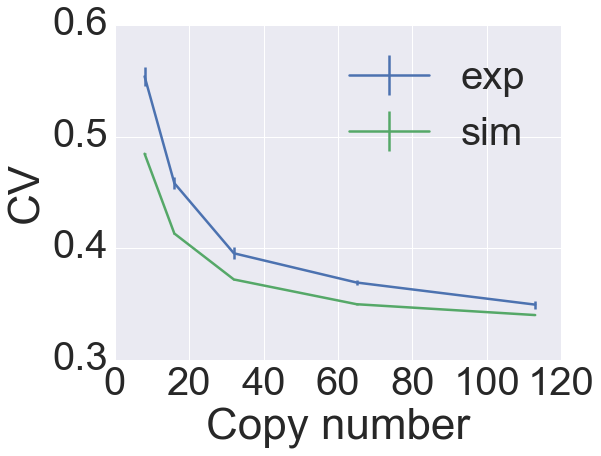

In [7]:
avg_copyNs = [113, 65, 32, 16, 8]
# plot data with standard error
sns.set_context("notebook", font_scale=4.0, rc={"lines.linewidth": 2.5})
plt.matplotlib.rcParams.update({'font.size':22})
fig, ax1 = plt.subplots(1,1,figsize=(8,6))
ax1.errorbar(avg_copyNs, CVs_exp_mean, CVs_exp_sd, label="exp")
ax1.errorbar(avg_copyNs, np.mean(CVs_sim_all, axis=0), CVs_sim_sd, label="sim")
ax1.set_ylabel("CV")
ax1.set_xlabel("Copy number")
ax1.set_yticks(np.linspace(0.3, 0.6, 4))
ax1.legend()
#plt.savefig('./figs/190204_CV_standardError.pdf', dpi=300, bbox_inches='tight')

In [8]:
from sklearn.metrics import r2_score
print r2_score(ffcSTDs_exp_mean, np.mean(ffcSTDs_sim_all, axis=0))
print r2_score(CVs_exp_mean, np.mean(CVs_sim_all, axis=0))

0.689298579342501
0.7137066291506696


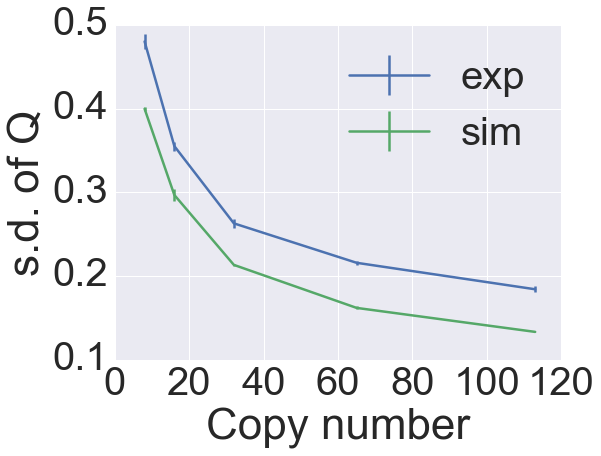

In [9]:
sns.set_context("notebook", font_scale=4.0, rc={"lines.linewidth": 2.5})
plt.matplotlib.rcParams.update({'font.size':22})
fig, ax1 = plt.subplots(1,1,figsize=(8,6))
ax1.errorbar(avg_copyNs, ffcSTDs_exp_mean, ffcsSTDs_exp_sd, label="exp")
ax1.errorbar(avg_copyNs, np.mean(ffcSTDs_sim_all, axis=0), ffcSTDs_sim_sd, label="sim")
ax1.set_ylabel("s.d. of Q")
ax1.set_xlabel("Copy number")
ax1.set_yticks(np.linspace(0.1,0.5, 5))
ax1.legend()
#plt.savefig('./figs/190204_Q_prediction_standardError.pdf', dpi=300, bbox_inches='tight')